# Spectral Analysis of Mitochondrial Dynamics: A Graph-Theoretic Approach to Understanding Subcellular Pathology

---

## Table of Contents

1. [Abstract](#Abstract)
2. [Introduction](#Introduction)
3. [Mitochondrial Dynamics](#Mitochondrial-Dynamics)
5. [Data](#Data)
4. [OrNet](#OrNet)
    * [Installation](#Installation)
    * [Constraining the video](#Constraining-the-video)
    * [Tracking cells / Updating Segementation masks](#Tracking-Cells-/-Updating-Segmentation-Masks)
    * [Median Normalization](#Median-Normalization)
    * [Downsampling](#Downsampling)
    * [Extract Cells](#Extract-Cells)
    * [Application of Gaussian Mixture Models](#Application-of-Gaussian-Mixture-Models)
    * [Compute mixture distribution distances](#Compute-mixture-distribution-distances)
    * [End-To-End Code](#End-to-End-Usage)
5. [Temporal Anomaly Detection](#Temporal-Anomaly-Detection)
6. [Spatial Anomaly Detection](#Spatial-Anomaly-Detection)
7. [Conclusion](#Conclusion)


---
    
## Abstract
    
Perturbations of organellar structures within a cell are useful indicators of the cell’s response to viral or bacterial invaders. Of the various organelles, mitochondria are meaningful to model because they show distinct migration patterns in the presence of potentially fatal infections, such as tuberculosis. Properly modeling and assessing mitochondria could provide new information about infections that can be leveraged to develop tests, treatments, and vaccines. Traditionally, mitochondrial structures have been assessed via manual inspection of fluorescent microscopy imagery. However, manual microscopy studies are labor-intensive and fail to provide a high-throughput for screenings. Thus, demonstrating the need for techniques that are more automated and utilize quantitative metrics for analysis. Yet, modeling mitochondria is no trivial task; mitochondria are amorphous, spatially diffuse structures that render traditional shape-based, parametric modeling techniques ineffective. We address the modeling task by using OrNet (Organellar Networks), a Python framework that utilizes probabilistic, graph-theoretic techniques to cast mitochondrial dynamics in the mold of dynamic social networks. We propose quantitative temporal and spatial anomaly detection techniques that leverage the graph connectivity information of the social networks to reveal time points of anomalous behavior and spatial regions where organellar structures undergo significant morphological changes related to a relevant change in environment or stimulus. We demonstrate the advantages of these techniques with the results of exhaustive graph-theoretic analyses over time in three different mitochondrial conditions. This methodology provides the quantification, visualization, and analysis techniques necessary for rigorous spatiotemporal modeling of diffuse organelles.

---

## Introduction
This poster will serve as an in-depth guide to explore the temporal and spatial anomaly detection methodologies utilized in our framework, OrNet, to assess mitochondrial dynamics. First we will present a brief overview of the entire framework, then describe ways to run the entire pipeline in an end-to-end manner or each stage individually with code examples.

---

## Mitochondrial Dynamics

Mitochondria are amorphous, spatially diffuse structures whose morphology exists within a dynamic continuum, ranging from fragmented individual mitochondrion to complex interconnected networks. The morphology of mitochondria transitions between many states along its spectrum, as a result of fission and fusion events, and the observation of these morphological changes is referred to as mitochondrial dynamics. Traditionally, analysis of mitochondrial dynamics was accomplished via manual inspection of microscopy imagery. However, manual approaches are labor-intensive, and are unscalable in terms of processing large volumes of data. Thus, we seek to elucidate mitochondrial dynamics by providing quantitative methodologies to measure spatial and temporal regions of anomalous morphological behavior in an automated manner via spectral analysis of dynamic social networks.

![dynamics](../images/dynamics.png)

---

## Data

We have provided live HeLa cell microscopy videos [here](https://github.com/Marcdh3/SciPy-2020/tree/master/samples) to test our techniques. The data is organized into three sub-directories that corresponds to the three different cell types we utilized in our experiments: control, llo, and mdivi. Control refers to the group of cells that were not exposed to any external stimulant; llo refers to the group that was exposed to listeriolysin O (llo), a pore-forming toxin, to induce mitochondrial fragmentation; and mdivi refers to the group that was exposed to mitochondrial-division inhibitor 1 (mdivi) to induce mitochondrial fusion. In all of the subsequent code examples we utilize the llo.mp4 microscopy video, however, we encourage everyone to test our techniques using the other videos as well.

---

## OrNet

[OrNet](https://github.com/quinngroup/ornet) is a Python framework that models the spatiotemporal relationships of subcellular organelles as dynamic social networks. In this context, a dynamic social network is a series of evolving graphs that captures the morphological state of an organelle at discrete points in time. We utilized OrNet to construct dynamic social networks of fluorescently tagged mitochondria in live microscopy videos so that we could leverage spectral graph theory techniques to perform temporal and anomaly detection. Below is an outline of OrNet's pipeline.


### Pipeline Stages:
* Constraining the video (Optional)
* Median Normalization
* Tracking cells / Updating Segementation Masks (Optional)
* Downsampling (Optional)
* Extract Cells
* Application of Gaussian Mixture Models
* Compute mixture distribution distances

![pipeline](../images/pipeline.png)

---

### Installation

OrNet is an open-source project, and the code is publicly available on Github: https://github.com/quinngroup/ornet.
Clone the repository, follow all installation steps detailed in the README, and run the test script to ensure that all dependencies are properly installed. 

---

### Constraining the video

This stage in the pipeline truncates video frames after a specified number. We performed this step in our experiments because in most of our microscopy videos the mitochondria within the cells stopped demonstrating morphological changes after a specific number of frames. However, if signifiant spatial events occur the entire duration of the video, this step can be avoided. For our experiments, we constrained the videos to a maximum of 20,000 frames.

In [2]:
import os
import numpy as np
from ornet.pipeline import constrain_vid

help(constrain_vid)

Help on function constrain_vid in module ornet.pipeline:

constrain_vid(vid_path, out_path, constrain_count, display_progress=True)
    Constrains the input video to specified number of frames, and write the
    result to an output video (.avi). If the video contains less frames than
    constrain_count, then then all frames of the video are returned.
    
    Parameters
    ----------
    vid_path: String
        Path to the input video.
    out_path: String
        Path to the output video.
    constrain_count: int
        First N number of frames to extract from the video.
        If value is -1, then the entire video is used.
    display_progress: bool
        Flag that indicates whether to show the progress bar
        or not.
    
    Returns
    ----------
    NoneType object



In [5]:
original_vid_path = '../samples/llo/llo.mp4'
constrained_vid_path = '../outputs/constrained_vid.mp4'

constrain_vid(original_vid_path, constrained_vid_path, 20000)

Constraining video:  66%|██████▌   | 13201/20000 [00:19<00:10, 665.48it/s]


**Note**: If the display_progress flag is set to True, notice the progress bar stopped at 66% because the length of the video was 13201 frames, which is less than the maximum specified. So if the video contains less frames than the maximum specified, then the entire video will be used.

---

### Tracking Cells / Updating Segmentation Masks

In most cases, live micrscopy videos contain multiple cells. However, our methodology consists of making dynamic social networks of an organelle contained within **one** cell, so we segment out each individual cell into its own video to mitigate the chances of constructing graphs with unlikely biological connections (e.g. inter-cellular connections between mitochondrial clusters), in the context of assessing organellar peturbations in response to cellular invaders. If the live microscopy video being processed only contains one cell, then this step can be skipped.

![Insert Image]()

This stage in the pipeline takes as input the microscopy video and a manually crafted segementation mask of the first video frame, then it iteratively computes segmentation masks for each subsequent frame in the video. The initial mask should be in the .itk format; we recommend using the [ITK-SNAP](http://www.itksnap.org/pmwiki/pmwiki.php) tool to generate the mask. The resulting list of segmentation of masks should then be saved as a NumPy array. 

In [20]:
from ornet.track_cells import track_cells

help(track_cells)

Help on function track_cells in module ornet.track_cells:

track_cells(vidfile, maskfile, show_video=False, display_progress=True)
    reads a video file and initial masks and returns a set of frames for each cell
    
    
    Parameters
    ----------
    vidfile : string
        path to a single video file
    maskfile : string
        path to a single vtk mask file
    show_video : boolean (Default : False)
        If true, display video with contours drawn during processing
    display_progress: bool
        Flag that indicates whether to show the progress bar
        or not.
    
    Returns
    ---------
    videos : Returns a list of arrays each with shape (H, W, F)



**Note**: If the show_video flag is used, press **"ESC"** to close the video. Do not click the exit button.

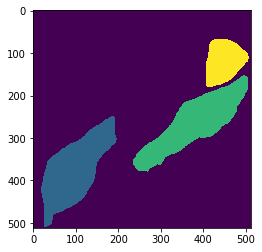

    Tracking cells: 100%|██████████| 13201/13201 [17:54<00:00, 12.29it/s]


In [7]:
initial_mask = '../samples/llo/llo.vtk'
full_vid_masks_path = '../outputs/llo_full_masks.npy'

masks = track_cells(constrained_vid_path, initial_mask, show_video=True)
np.save(full_vid_masks_path, masks)

---

### Median Normalization

Reduces noise in a microscopy video by preprocessing every frame using the median normalization technique.

In [10]:
from ornet.median_normalization import median_normalize

help(median_normalize)

Help on function median_normalize in module ornet.median_normalization:

median_normalize(vid_name, vid_path, out_path)
    Parameters
    ----------
    vid_name: String
        name for the output video
    vid_path: String
        path to the input video
    out_path: String
        path to the directory to save the ouptut video
    
    Returns
    ----------
    NoneType object



In [14]:
normalized_dir_path = '../outputs/normalized/'
median_normalize('normalized_vid', constrained_vid_path, normalized_dir_path)

 Normalizing video: 100%|██████████| 26402/26402 [00:43<00:00, 607.70it/s]


---

### Downsampling

The morphological change in mitochondrial structures can be nearly imperceptible between nearby video frames, especially when the frame of the microscopy video is high. Thus, we utilize a downsampling technique where we skip a specified number of frames. If video frames are downsampled, the corresponding masks must be downsampled accordingly; downsampling masks is handled by this function, as well. In our experiments we skip every 100 frames. This is an optional step.

In [13]:
from ornet.pipeline import downsample_vid

help(downsample_vid)

Help on function downsample_vid in module ornet.pipeline:

downsample_vid(vid_name, vid_path, masks_path, downsampled_path, frame_skip)
    Takes an input video and saves a downsampled version 
    of it, by skipping a specified number of frames. The
    saved video is (.avi) format.
    
    Parameters
    ----------
    vid_name: String
        Name of the input video.
    vid_path: String
        Path to the input video.
    masks_path: String
        Path to the input masks.
    downsampled_path:
        Path to directory where the downsampled video will be saved.
    frame_skip:
        The number of frames to skip for downsampling.
    
    Returns
    ----------
    NoneType object



The code below downsamples the median normalized video, which is a grayscale video, and is necessary for the [Gaussian Mixture Model stage](#Application-of-Gaussian-Mixture-Models).

In [18]:
normalized_vid_path = os.path.join(normalized_dir_path, "normalized_vid.avi")
downsampled_dir_path = '../outputs/downsampled'
downsample_vid("downsampled_normalized_vid",  normalized_vid_path, full_vid_masks_path, downsampled_dir_path, 100)

      Downsampling: 100%|██████████| 13201/13201 [00:09<00:00, 1401.35it/s]


The code below downsamples the constrained video, which is a RGB video, and is used during the extract cells step so that the individual cells can be visualized in color. Additionally, these videos are used during the [Spatial Anomaly Detection Stage](#Spatial-Anomaly-Detection).

In [17]:
downsample_vid("downsampled_color_vid", constrained_vid_path, full_vid_masks_path, downsampled_dir_path, 100)

      Downsampling: 100%|██████████| 13201/13201 [00:09<00:00, 1449.91it/s]


--- 

### Extract Cells

This stage of the pipeline separates each cell in the microscopy video into their own videos using the segmentation masks generated from tracking the cells movement. As a reminder, if the microscopy video only contains one cell, then this step can be skipped.

In [16]:
from ornet.extract_cells import extract_cells

help(extract_cells)

Help on function extract_cells in module ornet.extract_cells:

extract_cells(vid_path, masks_path, output_path, show_vid=False)
    Each individual cell in a video is extracted into it's own video.
    
    Parameters
    ----------
    vid_path: String
        Path to the input video.
    masks_path: String
        Path to the segmentation masks for the input video.
    output_path: String
        Path to the directory to save the individual videos.
    show_vid: boolean
        Flag to show video while extracting cells.
    
    Returns
    ----------
    NoneType object



In [17]:
# Extracts the cells from the grayscale videos
downsampled_normalized_vid_path = '../outputs/downsampled/downsampled_normalized_vid.avi'
downsampled_normalized_masks_path = '../outputs/downsampled/downsampled_normalized_vid.npy'
singles_dir_path = '../outputs/singles'
extract_cells(downsampled_normalized_vid_path, downsampled_normalized_masks_path, singles_dir_path, show_vid=False)

  Extracting cells: 100%|██████████| 133/133 [00:01<00:00, 76.97it/s]


In [18]:
# Extracts the cells from the RGB videos
downsampled_color_vid_path = '../outputs/downsampled/downsampled_color_vid.avi'
downsampled_color_masks_path = '../outputs/downsampled/downsampled_color_vid.npy'
extract_cells(downsampled_color_vid_path, downsampled_color_masks_path, singles_dir_path, show_vid=False)

  Extracting cells: 100%|██████████| 133/133 [00:01<00:00, 78.54it/s]


---

### Application of Gaussian Mixture Models

Gaussian Mixture Models (GMMs) are utilized to determine spatial regions of the microscopy imagery that corresponded to the mitochondrial clusters by iteratively updating the parameters of underlying mixture distributions until they converged. This approach assumes that the spatial locations of mitochondria are normally distributed with respect to their associated clusters. 

Our GMM functions requires as input NumPy arrays of the video frame, so we utilize the cells_to_gray script, which converts videos to NumPy arrays of grayscale frames. In scenarios where the video is already in grayscale, the video is just converted to an array and saved.

In [30]:
from ornet.cells_to_gray import vid_to_gray


for file_name in os.listdir(singles_dir_path):
    if 'normalized' in file_name:
        current_vid = os.path.join(singles_dir_path, file_name)
        vid_to_gray(current_vid, singles_dir_path)

Converting to gray: 100%|██████████| 133/133 [00:00<00:00, 1003.88it/s]


In [25]:
from ornet.pipeline import compute_gmm_intermediates

help(compute_gmm_intermediates)

Help on function compute_gmm_intermediates in module ornet.pipeline:

compute_gmm_intermediates(vid_dir, intermediates_path)
    Generate intermediate files from passing a grayscale video
    through the GMM portion of the pipeline.
    
    Parameters
    ----------
    vid_dir: String
        Path to the directory that contains the single videos.
    intermediates_path:
        Path to save the intermediate files.
    
    Returns
    ----------
    NoneType object



In [31]:
intermediates_dir_path = '../outputs/intermediates'
compute_gmm_intermediates(singles_dir_path, intermediates_dir_path)

Computing GMM info:   0%|          | 0/3 [00:00<?, ?it/s]

Disappering cell: downsampled_normalized_vid_2.npy


Computing GMM info: 100%|██████████| 3/3 [03:56<00:00, 78.85s/it] 


**Note**: In rare circumstances, a "Disappearing Cell" error may be encountered when processing a video through the GMM. That cell is ignored and the pipeline continues to process the remaining cells.

---

### Compute mixture distribution distances

The post-convergence parameters of the mixture distributions, specifically the means and covariances (stored in the files in the intermediates directory), are used for constructing the social network graph. The means corresponded to the center spatial coordinates of mitochondrial clusters, and for this reason they are selected to be the nodes in the graphs. The edges, which represent the relationships between clusters, are defined by the Hellinger distance between the respective mixture distributions. This modeling process occurrs for every frame in a microscopy video; therefore, each frame updates the state of the network’s graph at a discrete point in time.

In [32]:
from ornet.pipeline import compute_distances

help(compute_distances)

Help on function compute_distances in module ornet.pipeline:

compute_distances(intermediates_path, output_path)
    Generate distances between means using Hellinger Distance.
    
    Parameters
    ----------
    intermediates_path: String
        Path to the GMM intermediates.
    output_path: String
        Directory to save the distance ouptuts.
    
    Returns
    ----------
    NoneType object



In [33]:
distances_dir_path = '../outputs/distances'
compute_distances(intermediates_dir_path, distances_dir_path)

Computing distance: 100%|██████████| 2/2 [00:14<00:00,  7.26s/it]


---
### End-to-End Usage

All of the previous sections demonstrated how to run a specific stage of the pipeline independently, and provided details regarding why that specific stage is useful. However, running each stage independently can be time-consuming, so we provided a function to run the entire framework from end-to-end. Additionally, there is a command line interface that can also be utilized, and the details are described in the Github [repo's](https://github.com/quinngroup/ornet) README. 

In [5]:
from ornet.pipeline import run

help(run)

Help on function run in module ornet.pipeline:

run(input_path, initial_masks_dir, output_path, constrain_count=-1, downsample=1)
    Runs the entire ornet pipeline from start to finish for any video(s)
    found at the input path location.
    
    Paramaters
    ----------
    input_path: String
        Path to input video(s).
    initial_masks_dir: String
        Path to the directory contatining the initial 
        segmentation mask that corresponds with the input 
        video.
    output_path: String
        Path to the output directory.
    constrain_count: int
        The first N number of frames of the video to use.
    downsample: int
        The number of frames to skip when performing
        downsampling.
    
    Returns
    ----------
    NoneType object



---

## Temporal Anomaly Detection

Detecting when morphology-altering events occur is an important aspect to understanding mitochondrial dynamics. Temporal indicators of organellar activity improve qualitative assessments of microscopy imagery by eliminating the need to manually inspect every frame, only those that immediately precede or succeed an anomalous event. Additionally, the effects of local events on the global mitochondrial structure are more distinct. This process of indicating time points when distinct organellar activity is occurring is a temporal anomaly detection task. We addressed this task by utilizing the graph connectivity information of the dynamic social network; since the spatiotemporal relationships of mitochondria within a cell were modeled as a dynamic social network, the underlying graph states could be represented as Laplacian matrices and leveraged via utilization of Eigendecomposition to extract information regarding the connectdness of the graph.

In essence, our technique utilizes the eigenvalue vectors of each underlying graph state of a network to characterize the magnitude of spatial transformations experienced by the morphology and highlight the time points where the data is demonstrating anomalous behavior (i.e. time points that are outlier with respect to previous time points corresponding eigenvalue vectors). Therefore, morphology-altering events, like fission and fusion, are likely to be discovered by highlighting time points where eigenvalue vectors are demonstrating anomalous behavior.


In [50]:
from ornet.analysis.util import generate_eigens

help(generate_eigens)

Help on function generate_eigens in module ornet.analysis.util:

generate_eigens(input_dir, output_dir)
    Computes the eigenvalues and eigenvectors of
    distance matrices.
    
    Parameters
    ---------
    input_dir: string
        Path to the distance matrices. (.npy)
    ouput_dir: string
        Path to save the resulting eigen information.
    
    Returns
    -------
    NoneType object



In [51]:
eigen_data_dir_path = '../outputs/eigendata/'

generate_eigens(distances_dir_path, eigen_data_dir_path)

100%|██████████| 133/133 [00:00<00:00, 4219.43it/s]

downsampled_normalized_vid_1.npy
downsampled_normalized_vid_3.npy


In [5]:
from ornet.analysis.temporal_anomaly_detection import temporal_anomaly_detection

help(temporal_anomaly_detection)

Help on function temporal_anomaly_detection in module ornet.analysis.temporal_anomaly_detection:

temporal_anomaly_detection(vid_name, eigen_vals, outdir_path, k=10, window=20, threshold=2)
    Generates a figure comprised of a time-series plot
    of the eigenvalue vectors, and an outlier detection 
    signals plot.
    
    Parameters
    ----------
    vid_name: string
        Name of the microscopy video.
    eigen_vals: NumPy array (NXM)
        Matrix comprised of eigenvalue vectors. 
        N represents the number of frames in the
        corresponding video, and M is the number of
        mixture components.
    outdir_path: string
        Path to a directory to save the plots and anomalous
        time points.
    k: int
        The number of leading eigenvalues to display.
    window: int
        The size of the window to be used for anomaly 
        detection.
    threshold: float
        Value used to determine whether a signal value
        is anomalous.  
    
    Retur

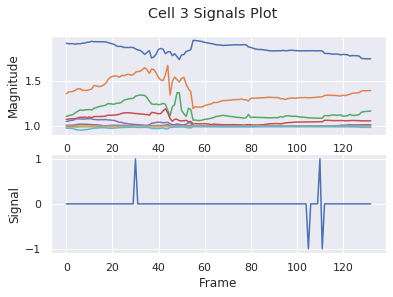

In [19]:
cell_3_eigen_path = '../outputs/eigendata/downsampled_normalized_vid_3.npz'
plots_dir_path = '../outputs/plots'
cell_3_eigen_data = np.load(cell_3_eigen_path)
cell_3_eigen_vals, cell_3_eigen_vecs = cell_3_eigen_data['eigen_vals'], cell_3_eigen_data['eigen_vecs']
temporal_anomaly_detection('Cell 3', cell_3_eigen_vals, plots_dir_path)

---

## Spatial Anomaly Detection

After indicating discrete times points where the morphology experienced significant perturbations, quantitatively determining the spatial locations of significant structural changes is crucial for assessing mitochondrial dynamics. Mitochondria are spatially diffuse structures that occupy a vast amount of the cell and, as a result, many areas of the cell require detailed inspection to identify all significant spatial changes. However, many structural perturbations go unnoticed when evaluated with purely qualitative metrics because of the large search space and the inherent difficulty in tracking microscopic objects. Thus, we sought to provide a quantitative technique to indicate spatial regions demonstrating anomalous morphological behavior.

Anomalous morphological behavior can be defined as spatial regions shifting suddenly, or major structural changes taking place in the underlying social network: edges being dropped or formed, nodes appearing or disappearing. The process of tracking such regions is, in essence, an object detection task because specific mitochondrial clusters are being monitored as the global structure evolves over time. By treating this task as such, we utilized bounding boxes to highlight the regions of significance. The coordinates of the bounding boxes were computed based on the pixel coordinates denoted by the GMMs that corresponded to the spatial locations of the mitochondrial clusters. Therefore, a bounding box can be displayed for each mitochondrial cluster determined by the GMM. 

Our code below only highlights the region demonstrating the most amount of variance. Regions demonstrating the most significant amount of structural variance are determined via analysis of the eigenvector matrices because each row in an eigenvalue matrix is related to a mixture distribution from the GMM, and by extension a spatial region of the imagery. To determine the region demonstrating the most amount of variance, the total euclidean distance of each row vector between graph states is computed.

In [8]:
from ornet.analysis.spatial_anomaly_detection import spatial_anomaly_detection

help(spatial_anomaly_detection)

Help on function spatial_anomaly_detection in module ornet.analysis.spatial_anomaly_detection:

spatial_anomaly_detection(vid_path, means, covars, eigen_vecs, k, outdir_path, std_threshold=3, display_areas=False)
    Draws bounding boxes around the mixture component
    regions demonstrating the most variance.
    
    Parameters
    ----------
    vid_path: string
        Path to the input video.
    means: NumPy array (NxMx2)
        Pixel coordinates corresponding to the mixture
        component means. N is the number of video frames,
        M the number of mixture components, and 2 denotes
        the 2D pixel coordinate.
    covars: NumPy array (NxMx2x2)
        Covariance matrices of the guassian mixture 
        components. N is the number of video frames,
        M is the number of mixture components, and 2x2
        denotes the covariance matrix.
    eigen_vecs: NumPy array (NxMxM)
        Eigenvector matrix. N represents the number of
        frames in the corresponding vid

In [13]:
cell_3_vid_path = '../outputs/singles/downsampled_color_vid_3.avi'
cell_3_inter_path = '../outputs/intermediates/downsampled_normalized_vid_3.npz'
cell_3_intermediates = np.load(cell_3_inter_path)
cell_3_means, cell_3_covars = cell_3_intermediates['means'], cell_3_intermediates['covars']
spatial_tracking_dir_path = '../outputs/spatial-tracking/'

spatial_anomaly_detection(cell_3_vid_path, cell_3_means, cell_3_covars, 
                          cell_3_eigen_vecs, 1, spatial_tracking_dir_path)

In [10]:
# Code to see the Spatial Tracking Video
from IPython.display import Video

Video("../outputs/spatial-tracking/downsampled_color_vid_3.mp4", html_attributes="controls auto loop")

---

## Conclusion

This poster served an interactive way to explore the functionality of OrNet, and utilize it to understand mitochondrial dynamics. We ultimately hope to use the proposed spatiotemporal analsysis techniques and the OrNet software package to conduct large-scale genomic screens of bacterial and viral mutants, in an effort to build a deeper understanding of how these pathogens invade cells and induce cell death at the genetic level. This work is one of the first steps toward that ultimate goal.